# PBMC3k dataset OT

In [1]:
import os
import subprocess

whoami = subprocess.run("whoami", stdout=subprocess.PIPE)
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/pbmc3k.h5ad")):
    !sh /home/jovyan/data/pbmc3k.sh

In [2]:
from typing import NamedTuple
import warnings
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import ot
import ot.plot
import pandas as pd
import scanpy as sc
import seaborn as sns

from grnet.anndata.preprocessing import binarize
from tools.preferences import kwarg_savefig
from tools.preprocessing import get_quantiles, filter_pipeline
from tools.go import top_degs, get_deg, go_plot

In [3]:
class Config(NamedTuple):
    data: ad.AnnData = sc.read_h5ad("/home/jovyan/data/pbmc3k_bin.h5ad")
    export: str = "/home/jovyan/output/pbmc3k"
    dsname: str = "PBMC3k"
    
conf = Config()
os.makedirs(conf.export, exist_ok=True)
warnings.filterwarnings("ignore")

In [4]:
from tools.plot import vinswarm

In [5]:
cov = pd.concat([
    binarize(conf.data[conf.data.obs["leiden"] == cluster_id, :]).var.assign(
        cluster_id=[cluster_id] * conf.data.shape[1]
    ) for cluster_id in conf.data.uns["rank_genes_groups"]["names"].dtype.names
])

In [6]:
conf.data[conf.data.obs["leiden"] == "8", :]

View of AnnData object with n_obs × n_vars = 11 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'coverage', 'DOR', 'Mean'
    uns: 'binarized', 'dsname', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


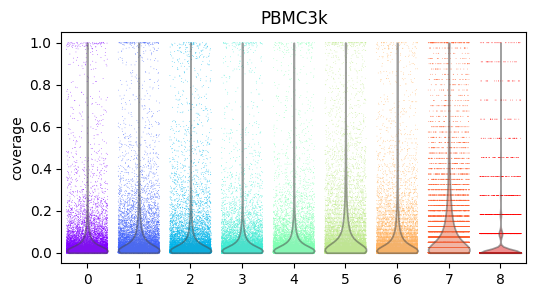

In [7]:
fig, ax = plt.subplots(figsize=(6, 3))

vinswarm(
    data=cov,
    x="cluster_id", y="coverage",
    hue="cluster_id",
    alpha=.5, jitter=.4, s=.5, ax=ax,
    palette=conf.data.uns["leiden_colors"]
)

ax.set(xlabel="", title=conf.dsname);

fig.savefig(f"{conf.export}/coverage.png", **kwarg_savefig)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


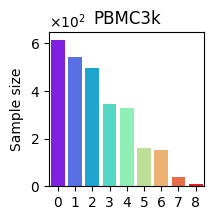

In [8]:
fig, ax = plt.subplots(figsize=(2, 2))

sns.barplot(
    data=pd.DataFrame({
        "sample_size": [
            conf.data[
                conf.data.obs["leiden"] == cluster_id, :
            ].shape[0] for cluster_id in conf.data.uns["rank_genes_groups"]["names"].dtype.names
        ],
        "cluster_id": conf.data.uns["rank_genes_groups"]["names"].dtype.names
    }),
    x="cluster_id", y="sample_size", hue="cluster_id", ax=ax,
    palette=conf.data.uns["leiden_colors"]
)

ax.ticklabel_format(
    axis="y", style="sci", scilimits=(2, 4), useMathText=True
)

ax.set(xlabel="", ylabel="Sample size", title=conf.dsname)

fig.savefig(f"{conf.export}/sample_size.png", **kwarg_savefig)

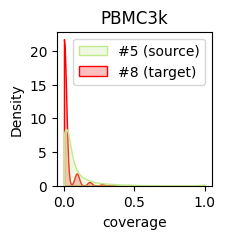

In [29]:
fig, ax = plt.subplots(figsize=(2, 2))

sns.kdeplot(
    binarize(
        conf.data[conf.data.obs["leiden"] == str(5), :]
    ).var.coverage, 
    cut=0, bw_method="silverman",
    color=conf.data.uns["leiden_colors"][5],
    fill=True, label="#5 (source)", zorder=2
)
sns.kdeplot(
    binarize(
        conf.data[conf.data.obs["leiden"] == str(8), :]
    ).var.coverage,
    cut=0, bw_method="silverman",
    color=conf.data.uns["leiden_colors"][8],
    fill=True, label="#8 (target)"
)

ax.set(title=conf.dsname)

ax.legend()

fig.savefig(f"{conf.export}/kde.png", **kwarg_savefig)

In [10]:
source = binarize(conf.data[conf.data.obs["leiden"] == str(5), :]).var.coverage
target = binarize(conf.data[conf.data.obs["leiden"] == str(8), :]).var.coverage

In [11]:
ot_emd = ot.da.EMDTransport(metric="sqeuclidean")
ot_emd.fit(
    Xs=source.values.reshape(-1, 1),
    Xt=target.values.reshape(-1, 1)
)

In [12]:
transformed = ot_emd.transform(Xs=source.values.reshape(-1, 1)).ravel()

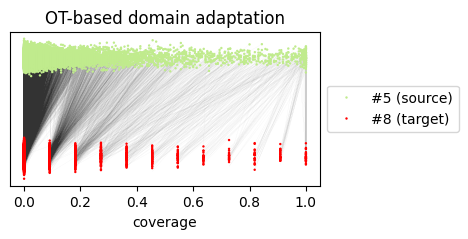

In [16]:
fig, ax = plt.subplots(figsize=(4, 2))

np.random.seed(0)

jitter = np.random.randn(source.size + target.size) / 20

sns.scatterplot(
    data=pd.DataFrame({
        "coverage": np.concatenate([source, target]),
        "cluster_id": ["#5 (source)"] * source.size + ["#8 (target)"] * target.size,
        "level": np.array([1] * source.size + [0] * target.size) + jitter,
    }),
    x="coverage", y="level", hue="cluster_id", s=3,
    palette = [
        conf.data.uns["leiden_colors"][5],
        conf.data.uns["leiden_colors"][8]
    ], linewidth=0

)

for xs, xtr, js, jtr in zip(source, transformed, jitter[:source.size], jitter[source.size:]):
    ax.plot(*np.array([
        [xs, xtr], 
        [1 + js, 0 + jtr]
    ]), c=".2", linewidth=.01, alpha=1, zorder=-1)

ax.legend(loc="center left", bbox_to_anchor=(1, .5))

ax.set(ylabel="")
ax.set_title("OT-based domain adaptation")
ax.tick_params(
    axis='both', which='both', 
    left=False, labelleft=False
)
fig.savefig(f"{conf.export}/ot.png", **kwarg_savefig)

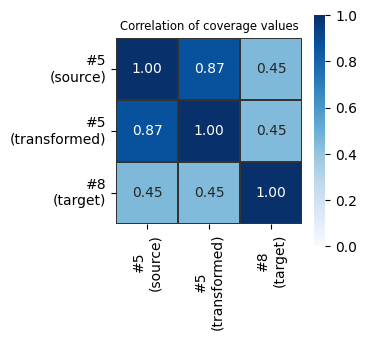

In [28]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.heatmap(
    data=pd.DataFrame({
        "#5\n(source)": source,
        "#5\n(transformed)": transformed,
        "#8\n(target)": target
    }).corr(),
    square=True, vmin=0, vmax=1,
    annot=True, fmt=".2f",
    cmap="Blues", ax=ax,
    linewidth=.1, linecolor=".2"
)

ax.set_title(
    "Correlation of coverage values",
    fontsize="small"
)

fig.savefig(f"{conf.export}/corr.png", **kwarg_savefig)